<a href="https://colab.research.google.com/github/Mastroiani/TCC/blob/Sandbox/MLDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><FONT COLOR="yellow">PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS</h1>
<h1><FONT COLOR="yellow">PÓS-GRADUAÇÃO LATO SENSU EM CIÊNCIA DE DADOS E BIG DATA</h1>
<h1><FONT COLOR="yellow">TCC - TRABALHO DE CONCLUSÃO DE CURSO</h1>
<br>
<ul>
<h3><strong><FONT SIZE=5>MODELOS SUPERVISIONADOS DE APRENDIZADO DE MÁQUINA APLICADOS À PREDIÇÃO DE INCOMPATIBILIDADE NO PREÇO DECLARADO DE MERCADORIAS IMPORTADAS
</h3>
</ul>


<h1> <FONT COLOR="yellow">NOTEBOOK 2 - DESENVOLVIMENTO DOS MODELOS DE ML<h1>

<h1><FONT COLOR="blue">
1 - Instalação de módulos e importação de bibliotecas utilizadas
<hr <FONT COLOR="blue">
</h1>

In [1]:
!pip install plotly
!pip install graphviz

In [18]:
import pandas as pd
import numpy as np

from time import time

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image  
import pydotplus
import pickle

import seaborn as sns
from sklearn import metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals.six import StringIO

<h1><FONT COLOR="blue">
2 - Carregando o dataset preprocessado no objeto 'df' (dataframe)
<hr <FONT COLOR="blue">
</h1>

In [6]:
path = '/content/drive/MyDrive'
name = 'dataset_preprocessado_TCC'

df = pd.read_csv(f'{path}/{name}')
df.shape

(1165, 34)

In [7]:
#Convertendo categorias do atributo 'unidade_desembaraço' em classes numéricas
map_portos = {porto:num for num,porto in enumerate(df['unidade_desembaraco'].value_counts().index)}

df['unidade_desembaraco'] = df['unidade_desembaraco'].apply(lambda x: map_portos[x])

In [8]:
df['unidade_desembaraco'].tail(2)

1163    0
1164    0
Name: unidade_desembaraco, dtype: int64

<h1><FONT COLOR="blue">3 - Definindo bases de treino e teste</h1>
<hr <FONT COLOR="blue"></hr>
<h2>Definindo variáves usadas no treinamento (X) e variável target (y)</h2>

In [10]:
X = df[['pais','pais_1','unidade_desembaraco',
       'qtde_estatistica',
       'vmle_dolar',
       'vl_frete_dolar',
       'vl_seguro_dolar',
       'valor_un_prod_dolar',
       'qtd_comercial',
       'tot_un_prod_dolar',
       'peso_liquido_rateado',
       'valor_frete_rateado',
       'seguro_rateado',
       'total_unitario_fob',
       'fob_kg'
       ]]

y = df[['incompatibil']]

In [11]:
X[['qtde_estatistica',
       'vmle_dolar',
       'vl_frete_dolar',
       'vl_seguro_dolar',
       'valor_un_prod_dolar',
       'qtd_comercial',
       'tot_un_prod_dolar',
       'peso_liquido_rateado',
       'valor_frete_rateado',
       'seguro_rateado',
       'total_unitario_fob',
       'fob_kg'
       ]].describe()

,qtde_estatistica,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_fob,fob_kg
count,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000
mean,63926.146481,54683.757288,9949.058893,93.693236,514.458350,8516.297596,20332.890191,22301.789472,2870.108652,33.405997,19502.088543,0.927707
std,57442.979954,47405.396227,16872.624953,146.870970,516.508709,17778.553120,22312.458141,24151.456588,4906.286784,64.138424,21554.872333,0.346492
min,120.000000,296.120000,12.230000,0.000000,0.218700,0.080000,17.200000,19.000000,3.927243,0.000000,17.200000,0.079966
25%,25000.000000,22318.770000,1103.800000,0.000000,0.912000,14.530000,4944.000000,5490.000000,312.500000,0.000000,4865.900000,0.755000
50%,50000.000000,38878.140000,3215.000000,30.390000,700.000000,50.446000,15008.474987,17720.000000,979.967782,7.100819,14420.000000,0.855352
75%,80730.000000,69807.790000,10000.000000,124.710000,877.000000,10500.000000,25789.500407,26000.000000,3311.106667,36.448652,24734.380368,0.995000
max,258833.000000,209807.370000,80550.000000,1088.350000,2600.000000,200000.000000,188908.400000,200000.000000,53466.000000,705.990000,180807.070000,4.957626


<h2>Definindo bases de treino e de teste</h2>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 64)

In [13]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(815, 15) (350, 15) (815, 1) (350, 1)


<h2>Definindo funções utilizadas para desenvolvimento dos modelos</h2>


1.   mostra_confusion_matrix: plota a matriz confusão em conjunto das estatísticas de teste relacionadas (acurácia, precisão, revocação e f1 score)
2.   train_model: executa o treinamento do modelo

In [14]:
def mostra_confusion_matrix(cf,
    group_names = None, categories = 'auto', count = True, percent = True, cbar = True, xyticks = False, xyplotlabels = True, sum_stats = True, figsize = (6, 6), cmap = 'Reds'):
    
    # Gera o texto dentro de cada quadrado
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # Gera estastísticas de teste
    if sum_stats:
        accuracy = np.trace(cf) / float(np.sum(cf))

        # caso se trate de matriz confusão binária informa estatísticas adicionais (Precisão, Revocação e F1 Score)
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAcurácia={:0.4f}\nPrecisão={:0.4f}\nRevocação={:0.4f}\nF1 Score={:0.4f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAcurácia={:0.4f}".format(accuracy)
    else:
        stats_text = ""

    # Plota o mapa de calor
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

In [15]:
# função de treinamento do modelo
def train_model(model):
    model.fit(X_train, y_train)
    
    # argumentos da função 'mostra_confusion_matrix'
    cf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cf_categories = [0,1]
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    
    #função de plotagem da matriz confusão e estatísticas de teste relacionadas ao modelo
    mostra_confusion_matrix(cm, group_names = cf_labels, categories= cf_categories)

<h1><FONT COLOR="blue">4 - Modelo de Máquina Suporte de Vetores</h1>
<hr <FONT COLOR="blue"></hr>

  <h10>Obs.: modelo apresentou resultado pobre quanto às estatísticas de teste (em especial revocação e f1 score)</h10>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



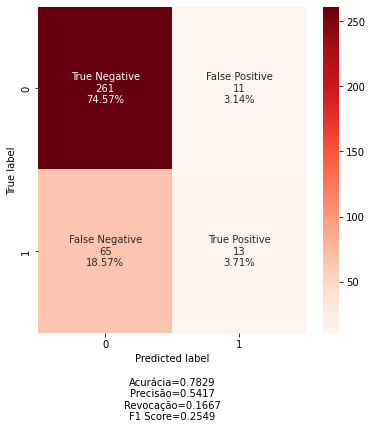

In [16]:
# instanciando modelo 'ml_SVC' de hiperparâmetros default
ml_SVC = SVC()

# executando o treinamento do modelo
train_model(ml_SVC)

<h1><FONT COLOR="blue">5 - Modelo Naive Bayes</h1>
<hr <FONT COLOR="blue"></hr>

  <h10>Obs.: modelo apresentou resultado pobre quanto às estatísticas de teste (em especial revocação e f1 score)</h10>

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



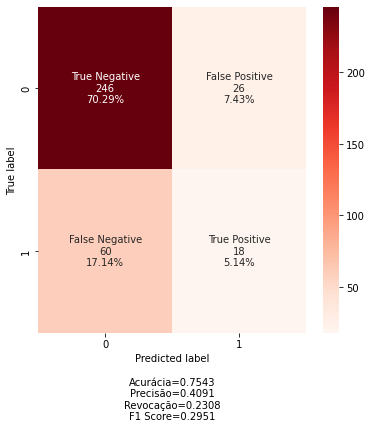

In [19]:
# instanciando modelo 'ml_SVC' de hiperparâmetros default
ml_GNB = GaussianNB()

# executando o treinamento do modelo
train_model(ml_GNB)

<h1><FONT COLOR="blue">6 - Modelo de Árvore de Decisão</h1>
<hr <FONT COLOR="blue"></hr>

<h4>Realizando o treinamento com hiperparâmetros default</h4>

True

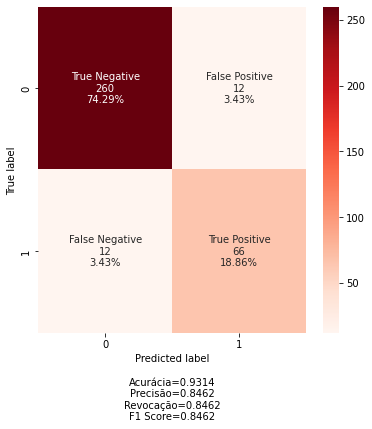

In [20]:
# instanciando modelo 'ml_DT' de hiperparâmetros default (apenas definido random_state pra efeito de reprodutibilidade das amostras)
ml_DT = DecisionTreeClassifier(random_state=64)

# executando o treinamento do modelo
train_model(ml_DT)

# gerando e salvando a respectiva àrvore de decisão
dot_data = StringIO()
export_graphviz(ml_DT, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('/content/drive/MyDrive/DecisionTree.png')

<h4>Apresentação das estatísticas de treino e teste</h4>
  <h10>Nota: Verificado overfitting sobre a base de treinamento, apesar do bom resultado apresentado na base de teste</h10>

In [21]:
print('*********** Estatísticas da Base de Treinamento ************************\n')
print(metrics.classification_report(y_train, ml_DT.predict(X_train), target_names=['0','1']))

print('*********** Estatísticas da Base de Teste ******************************\n')
print(metrics.classification_report(y_test, ml_DT.predict(X_test), target_names=['0','1']))

*********** Estatísticas da Base de Treinamento ************************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       633
           1       1.00      1.00      1.00       182

    accuracy                           1.00       815
   macro avg       1.00      1.00      1.00       815
weighted avg       1.00      1.00      1.00       815

*********** Estatísticas da Base de Teste ******************************

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       272
           1       0.85      0.85      0.85        78

    accuracy                           0.93       350
   macro avg       0.90      0.90      0.90       350
weighted avg       0.93      0.93      0.93       350



In [22]:
ml_DT

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')

<h4>Apresentação da Árvore de Decisão</h4>
  <h10>Obs.: complexidade da árvore demonstra necessidade de poda e ajuste de hiperparâmetros (tunning)</h10>

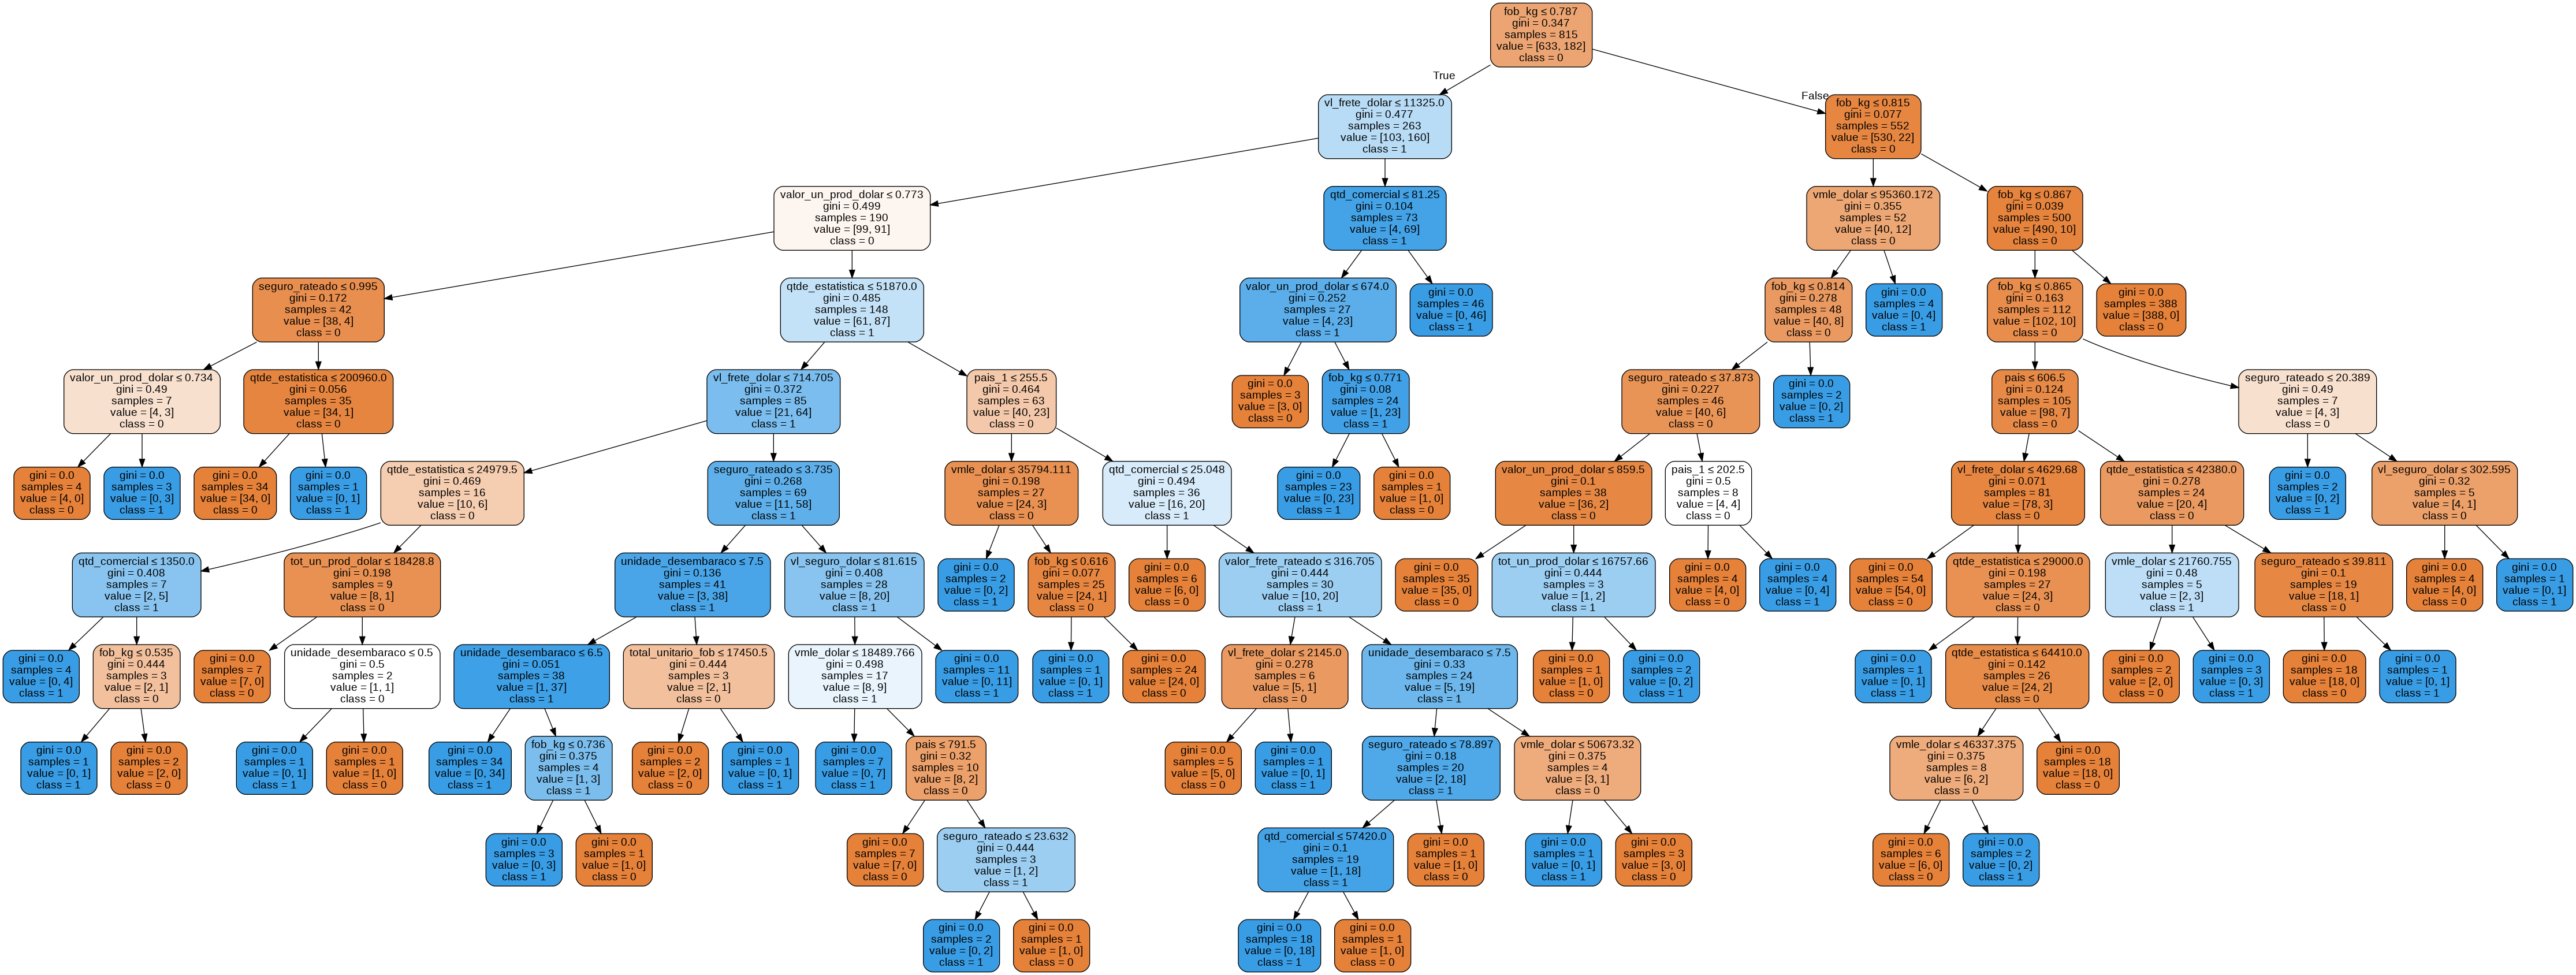

In [23]:
Image(graph.create_png())

In [24]:
y_pred = ml_DT.predict(X_test)
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [25]:
print(np.array(y['incompatibil'].to_list()))

[0 0 0 ... 0 0 0]


<h4>Aplicando a Cross Validation (k=10)</h4>

In [26]:
ml_DT_a_scores_CV = cross_val_score(ml_DT, X_train, y_train, cv = 10)
print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT_a_scores_CV.mean(),4)}')
print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT_a_scores_CV.std(),4)}')
ml_DT_a_scores_CV

Média das Acurácias calculadas pelo CV....: 91.16
std médio das Acurácias calculadas pelo CV: 3.16


array([0.92682927, 0.8902439 , 0.92682927, 0.90243902, 0.92682927,
       0.9382716 , 0.97530864, 0.86419753, 0.87654321, 0.88888889])

<h4>Salvando o Modelo 'ml_DT'</h4>

In [27]:
file_name = '/content/drive/MyDrive/ml_DT.pkl'
pickle.dump(ml_DT, open(file_name,'wb'))

<h2>Otimização de Hiperparâmetros</h2>
<h10>Visa diminuir overfitting e promover diminuição de complexidade da árvore com manutenção de boa capacidade preditiva e de generalização<h10>
</ul>
<h4>Para tanto desenvolvida a função 'GridSearchOptimizer', que busca:</h4>
<ul>
    <li>definir os melhores hiperparâmetros;</li>
    <li>realizar treinamento e cross validation com os hiperparâmetros otimizados;</li>
    <li>definir importância das variáveis na construção do modelo.</li>
</ul>

In [28]:
def GridSearchOptimizer(modelo, ml_Opt, d_hiperparametros, X_train, y_train, X_test, y_test, i_CV):
    
    # Realiza GridSearchCV em busca dos melhores hiperparâmetros
    ml_GridSearchCV = GridSearchCV(modelo, d_hiperparametros, cv = i_CV, n_jobs = -1, verbose= 10, scoring = 'accuracy')
    start = time()
    ml_GridSearchCV.fit(X_train, y_train)
    tempo_elapsed = time()-start
    print(f"\nGridSearchCV levou {tempo_elapsed:.2f} segundos.")

    # Imprimi hiperparâmetros que otimizam a classificação
    print(f'\nHiperparâmetros otimizados: {ml_GridSearchCV.best_params_}')

    if ml_Opt == 'ml_DT2':
      print(f'\nDecisionTreeClassifier *********************************************************************************************************')
      ml_Opt = DecisionTreeClassifier(criterion= ml_GridSearchCV.best_params_['criterion'], 
                                    max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                    max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                    min_samples_split= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                    min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_split'],
                                    min_impurity_decrease= ml_GridSearchCV.best_params_['min_impurity_decrease'],
                                    random_state= 64)

    # Treina novamente usando os hiperparâmetros otimizados
    ml_Opt.fit(X_train, y_train)

    # Cross-Validation com k=10
    print(f'\n********* CROSS-VALIDATION ***********')
    ml_DT2_a_scores_CV = cross_val_score(ml_Opt, X_train, y_train, cv = 10)
    print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT2_a_scores_CV.mean(),4)}')
    print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT2_a_scores_CV.std(),4)}')
    print(ml_DT2_a_scores_CV)

    # Faz predições com os hiperparâmetros otimizados...
    y_pred = ml_Opt.predict(X_test)

    # Defini e imprimi importância das colunas (variáveis)
    print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
    df_importancia_variaveis = pd.DataFrame(zip(X.columns, ml_Opt.feature_importances_), columns= ['coluna', 'importancia'])
    df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
    print(df_importancia_variaveis)

    # Plotagem da matriz de confusão e estatísticas de teste
    print(f'\n********* CONFUSION MATRIX - PARAMETER TUNNING ***********')
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cf_categories = [0,1]
    mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

    return ml_Opt, ml_GridSearchCV.best_params_

In [33]:
# Instanciando argumentos da função
i_CV = 10
d_hiperparametros_DT = {"criterion": ["gini", "entropy"], 
                   "min_samples_split": [2, 5, 10, 20, 30, 40, 50, 100], 
                   "max_depth": [None, 2, 5, 9, 15], 
                   "min_samples_leaf": [1.0, 5, 10, 15, 20, 40, 50, 100], 
                   "max_leaf_nodes": [None, 2, 3, 15],
                   "min_impurity_decrease": [0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.0]}
d_hiperparametros_DT

{'criterion': ['gini', 'entropy'],
 'max_depth': [None, 2, 5, 9, 15],
 'max_leaf_nodes': [None, 2, 3, 15],
 'min_impurity_decrease': [0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.0],
 'min_samples_leaf': [1.0, 5, 10, 15, 20, 40, 50, 100],
 'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100]}

In [ ]:
""" Instanciando argumentos da função
i_CV = 10
d_hiperparametros_DT = {"criterion": ["gini", "entropy"], 
                   "min_samples_split": [2, 5, 10, 270, 350, 400], 
                   "max_depth": [None, 2, 5, 9, 15], 
                   "min_samples_leaf": [1.0, 20, 40, 100], 
                   "max_leaf_nodes": [None, 2, 3, 15],
                   "min_impurity_decrease": [0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.0]}
d_hiperparametros_DT"""

<h4>Aplicando a função 'GridSearchOptimizer' ao modelo</h4>

Fitting 10 folds for each of 17920 candidates, totalling 179200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1938s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0411s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0437s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0961s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1853s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    4.8s
[Parallel(n


GridSearchCV levou 1010.59 segundos.

Hiperparâmetros otimizados: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.002, 'min_samples_leaf': 5, 'min_samples_split': 2}

DecisionTreeClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********
Média das Acurácias calculadas pelo CV....: 92.02
std médio das Acurácias calculadas pelo CV: 3.32
[0.95121951 0.91463415 0.93902439 0.8902439  0.93902439 0.9382716
 0.97530864 0.91358025 0.87654321 0.86419753]

********* IMPORTÂNCIA DAS COLUNAS ***********
                  coluna  importancia
14                fob_kg     0.554417
5         vl_frete_dolar     0.129550
7    valor_un_prod_dolar     0.098711
3       qtde_estatistica     0.062375
4             vmle_dolar     0.038744
1                 pais_1     0.027648
12        seguro_rateado     0.020466
8          qtd_comercial     0.020160
0                  

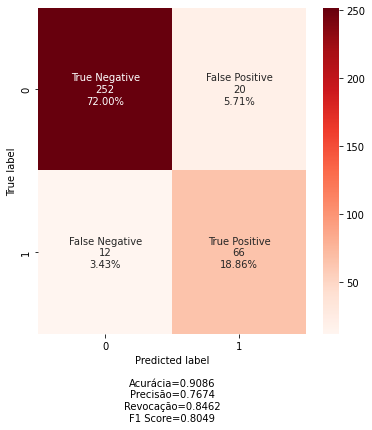

In [34]:
ml_DT2, best_params = GridSearchOptimizer(ml_DT, 'ml_DT2', d_hiperparametros_DT, X_train, y_train, X_test, y_test, i_CV)

<h4>Apresentação da Árvore de Decisão</h4>

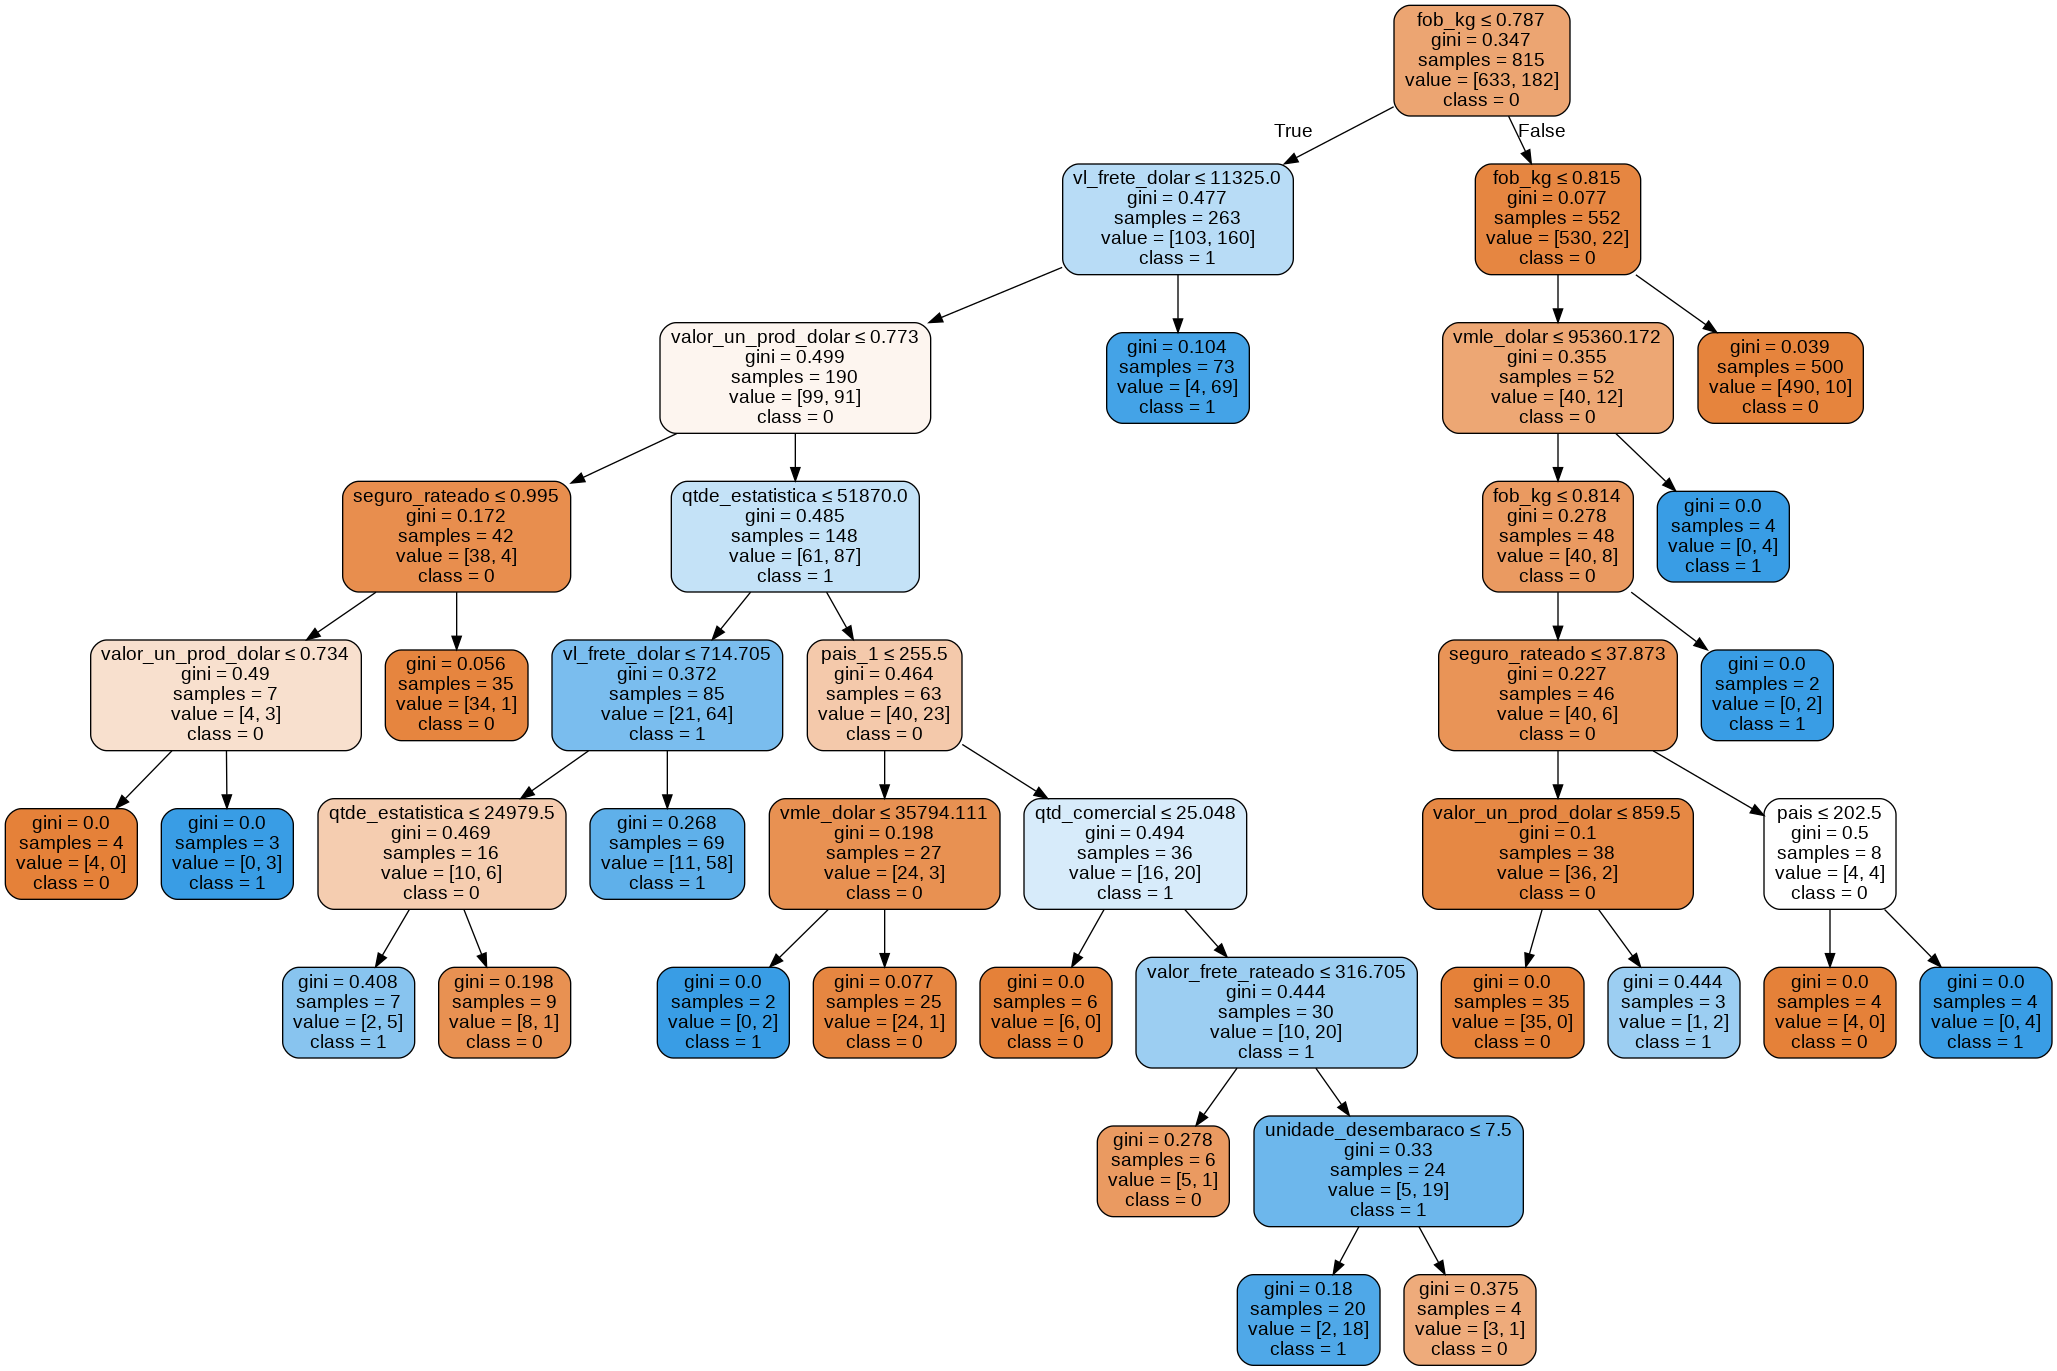

In [35]:
dot_data = StringIO()
export_graphviz(ml_DT2, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph2 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph2.write_png('/content/drive/MyDrive/DecisionTree2.png')
Image(graph2.create_png())

In [36]:
file_name = '/content/drive/MyDrive/ml_DT2.pkl'
pickle.dump(ml_DT2, open(file_name,'wb'))

<h2>Refazendo o treinamento com os hiperparâmetros otimizados</h2>

True

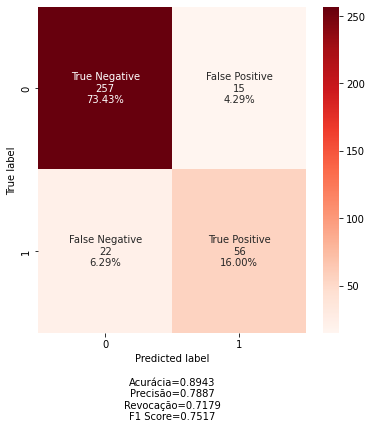

In [70]:
# instanciando modelo 'ml_DT3' com hiperparâmetros otimizados
ml_DT3 = DecisionTreeClassifier(criterion='gini', max_depth= None, max_leaf_nodes=None, min_impurity_decrease= 0.002, min_samples_leaf= 5, min_samples_split= 2, random_state=64)

# executando o treinamento do modelo
train_model(ml_DT3)

# gerando e salvando a respectiva àrvore de decisão
dot_data = StringIO()
export_graphviz(ml_DT3, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph3 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph3.write_png('/content/drive/MyDrive/DecisionTree3.png')

<h4>Apresentando estatísticas de treinamento e teste</h4>
  <h10>Nota: Verificada a diminuição do overfitting sobre a base de treinamento, sendo mantido bom resultado sobre a base de teste (indicativo de boa capacidade de generalização do modelo)</h10>

In [71]:
print('*********** Estatísticas de Resumo - Base de Treinamento ************************\n')
print(metrics.classification_report(y_train, ml_DT3.predict(X_train), target_names=['0','1']))
print('*********** Estatísticas de Resumo - Base de Teste ******************************\n')
print(metrics.classification_report(y_test, ml_DT3.predict(X_test), target_names=['0','1']))

*********** Estatísticas de Resumo - Base de Treinamento ************************

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       633
           1       0.89      0.84      0.87       182

    accuracy                           0.94       815
   macro avg       0.92      0.91      0.92       815
weighted avg       0.94      0.94      0.94       815

*********** Estatísticas de Resumo - Base de Teste ******************************

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       272
           1       0.79      0.72      0.75        78

    accuracy                           0.89       350
   macro avg       0.85      0.83      0.84       350
weighted avg       0.89      0.89      0.89       350



In [72]:
pred = ml_DT3.predict(X_train)

acc = accuracy_score(y_train, pred)
prec = precision_score (y_train, pred)
recall = recall_score(y_train, pred ,average='binary')
f1 = f1_score(y_train, pred)

print(f'Acurácia: {round(acc,4)}\nPrecision: {round(prec,4)}\nRevocação: {round(recall,4)}\nF1 Score: {round(f1,4)}')

Acurácia: 0.9423
Precision: 0.8947
Revocação: 0.8407
F1 Score: 0.8669


In [73]:
ml_DT3

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')

<h4>Apresentando da Árvore de Decisão</h4>
  <h10>Obs.: notável diminuição da complexidade por meio da poda efetuada através do ajuste de hiperparâmetros</h10>

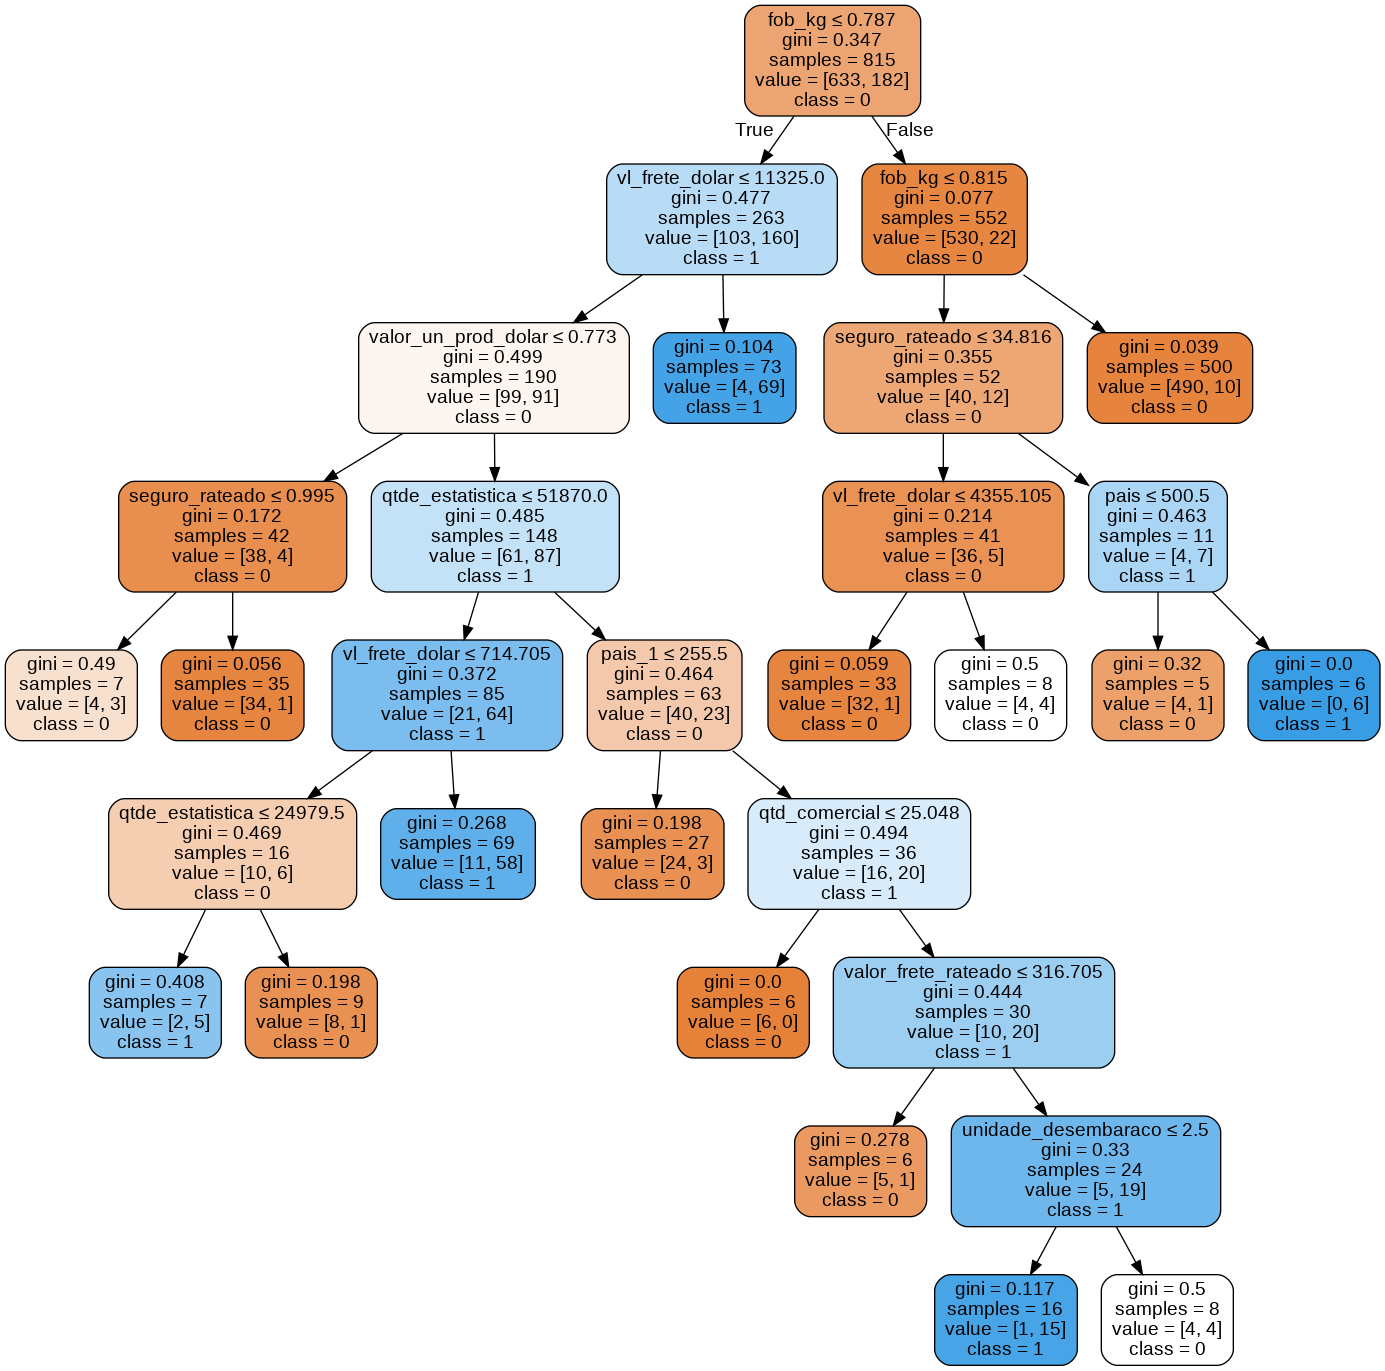

In [74]:
Image(graph3.create_png())

<h4>Aplicando a Cross Validation (k=10)</h4>

In [75]:
ml_DT3_a_scores_CV = cross_val_score(ml_DT3, X_train, y_train, cv = 10)
print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT3_a_scores_CV.mean(),4)}')
print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT3_a_scores_CV.std(),4)}')
ml_DT3_a_scores_CV

Média das Acurácias calculadas pelo CV....: 90.55
std médio das Acurácias calculadas pelo CV: 2.12


array([0.87804878, 0.90243902, 0.92682927, 0.87804878, 0.93902439,
       0.91358025, 0.92592593, 0.91358025, 0.90123457, 0.87654321])

<h4>Salvando o Modelo 'ml_DT3'</h4>

In [76]:
file_name = '/content/drive/MyDrive/ml_DT3.pkl'
pickle.dump(ml_DT3, open(file_name,'wb'))